# MLP con Undersampling - Binary Classification

**Modello:** Multi-Layer Perceptron con supporto Metal (MPS)

**Dataset:** Processed v3 con RandomUnderSampler

**Bilanciamento:** Undersampling classe maggioritaria (Non-TP) a ratio 1.5:1

**Vantaggi undersampling:**
- Riduce dataset size → training più veloce
- Bilancia classi senza sample sintetici
- Migliora precision/recall per classe minoritaria

**Pipeline:**
1. Undersampling training set (test set invariato)
2. Training MLP su dati bilanciati
3. Confronto con baseline

## 1. Setup

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"imbalanced-learn version: {__import__('imblearn').__version__}")

Device: mps
PyTorch version: 2.9.0
imbalanced-learn version: 0.14.0


## 2. Caricamento Dati

In [26]:
print("Caricamento dati...\n")

X_train = pd.read_csv('../data/processed_v3_balanced/X_train.csv')
X_test = pd.read_csv('../data/processed_v3_balanced/X_test.csv')
y_train = pd.read_csv('../data/processed_v3_balanced/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v3_balanced/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

print(f"\n{'='*60}")
print("DISTRIBUZIONE ORIGINALE (Training Set)")
print(f"{'='*60}")
class_counts_orig = y_train.value_counts().sort_index()
print(f"Classe 0 (Non-TP): {class_counts_orig[0]:,} ({class_counts_orig[0]/len(y_train)*100:.2f}%)")
print(f"Classe 1 (TP):     {class_counts_orig[1]:,} ({class_counts_orig[1]/len(y_train)*100:.2f}%)")
print(f"Imbalance ratio:   {class_counts_orig[0]/class_counts_orig[1]:.2f}:1")

Caricamento dati...

X_train: (348918, 43)
X_test: (149537, 43)

DISTRIBUZIONE ORIGINALE (Training Set)
Classe 0 (Non-TP): 247,302 (70.88%)
Classe 1 (TP):     101,616 (29.12%)
Imbalance ratio:   2.43:1


## 3. Random UnderSampling

In [27]:
print("\nApplicazione RandomUnderSampler...\n")

# Calcola target samples per ratio 1.5:1
n_minority = (y_train == 1).sum()  # TP count
n_majority_target = int(n_minority * 1.5)  # 1.5x i TP

# sampling_strategy come dizionario: {classe: n_samples}
sampling_strategy = {0: n_majority_target}  # Riduci classe 0 (Non-TP)

print(f"Target samples - Classe 0: {n_majority_target:,} (ratio 1.5:1)")

rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=42
)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(f"\n{'='*60}")
print("DOPO UNDERSAMPLING")
print(f"{'='*60}")
print(f"X_train_resampled: {X_train_resampled.shape}")
class_counts_res = pd.Series(y_train_resampled).value_counts().sort_index()
print(f"Classe 0 (Non-TP): {class_counts_res[0]:,} ({class_counts_res[0]/len(y_train_resampled)*100:.2f}%)")
print(f"Classe 1 (TP):     {class_counts_res[1]:,} ({class_counts_res[1]/len(y_train_resampled)*100:.2f}%)")
print(f"Imbalance ratio:   {class_counts_res[0]/class_counts_res[1]:.2f}:1")

reduction = (1 - len(y_train_resampled)/len(y_train)) * 100
print(f"\n✅ Riduzione dataset: {reduction:.1f}% (da {len(y_train):,} a {len(y_train_resampled):,} samples)")


Applicazione RandomUnderSampler...

Target samples - Classe 0: 152,424 (ratio 1.5:1)

DOPO UNDERSAMPLING
X_train_resampled: (254040, 43)
Classe 0 (Non-TP): 152,424 (60.00%)
Classe 1 (TP):     101,616 (40.00%)
Imbalance ratio:   1.50:1

✅ Riduzione dataset: 27.2% (da 348,918 a 254,040 samples)


## 4. Visualizzazione Distribuzione

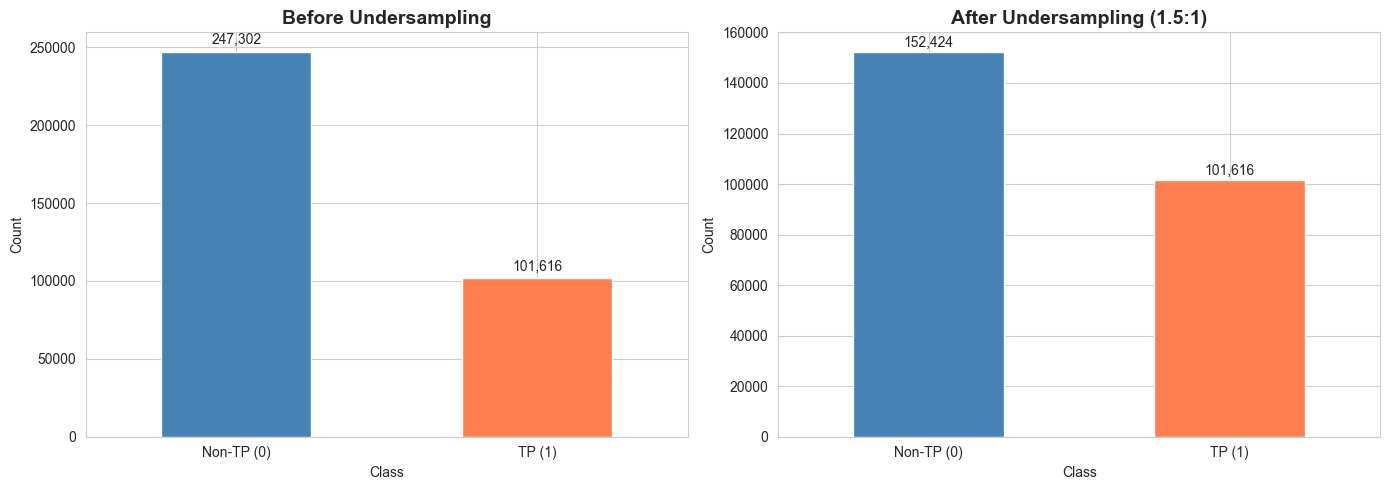

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
class_counts_orig.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Before Undersampling', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-TP (0)', 'TP (1)'], rotation=0)
for i, v in enumerate(class_counts_orig):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center')

# After
class_counts_res.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('After Undersampling (1.5:1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-TP (0)', 'TP (1)'], rotation=0)
for i, v in enumerate(class_counts_res):
    axes[1].text(i, v + 2000, f'{v:,}', ha='center')

plt.tight_layout()
plt.show()

## 5. Standardizzazione

In [29]:
# Standardizza su dati resampled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("✅ Dati standardizzati")

✅ Dati standardizzati


## 6. Preparazione DataLoaders

In [30]:
# Converti a tensori
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 497
Test batches: 293


## 7. Definizione MLP

In [31]:
class MLP(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Modello e loss (NO class weights, dati già bilanciati!)
input_dim = X_train_scaled.shape[1]
model = MLP(input_dim, dropout=0.3).to(device)
criterion = nn.BCEWithLogitsLoss()  # No pos_weight!
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n✅ Loss function: BCEWithLogitsLoss (no class weights, dati bilanciati)")

MLP(
  (network): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 16,449

✅ Loss function: BCEWithLogitsLoss (no class weights, dati bilanciati)


## 8. Training Loop

In [32]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    
    return np.array(all_labels).flatten(), np.array(all_preds).flatten(), np.array(all_probs).flatten()

# Training
print("Training MLP con undersampled data...\n")
n_epochs = 30
train_losses = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 5 == 0:
        y_true, y_pred, y_probs = evaluate(model, test_loader, device)
        auc = roc_auc_score(y_true, y_probs)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f} - Test AUC: {auc:.4f}")

print("\n✅ Training completato!")

Training MLP con undersampled data...

Epoch 5/30 - Loss: 0.4175 - Test AUC: 0.8899
Epoch 10/30 - Loss: 0.3580 - Test AUC: 0.9134
Epoch 15/30 - Loss: 0.3538 - Test AUC: 0.9127
Epoch 20/30 - Loss: 0.3518 - Test AUC: 0.9154
Epoch 25/30 - Loss: 0.3415 - Test AUC: 0.9176
Epoch 30/30 - Loss: 0.3398 - Test AUC: 0.9188

✅ Training completato!


## 9. Training Curve

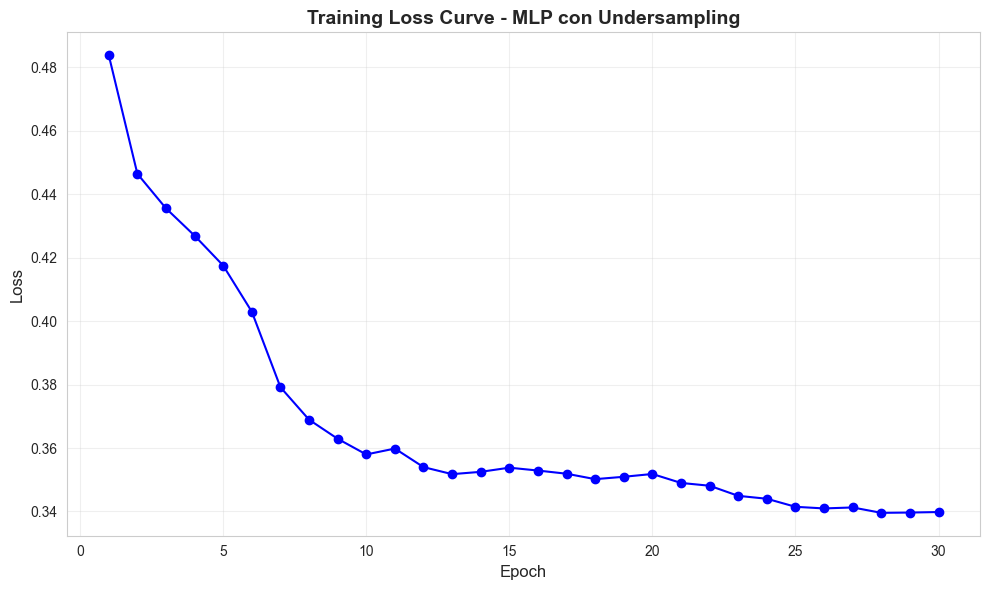

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve - MLP con Undersampling', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Evaluation

In [34]:
y_true, y_pred, y_probs = evaluate(model, test_loader, device)

print("="*70)
print("PERFORMANCE TEST SET - MLP con Undersampling")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                           target_names=['Non-TP', 'TP'], digits=4))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

print(f"\nPRECISION: {precision:.4f}")
print(f"RECALL:    {recall:.4f}")
print(f"F1-SCORE:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f} ⭐")

PERFORMANCE TEST SET - MLP con Undersampling

Classification Report:
              precision    recall  f1-score   support

      Non-TP     0.8827    0.9541    0.9170    105987
          TP     0.8609    0.6913    0.7668     43550

    accuracy                         0.8776    149537
   macro avg     0.8718    0.8227    0.8419    149537
weighted avg     0.8763    0.8776    0.8732    149537


PRECISION: 0.8609
RECALL:    0.6913
F1-SCORE:  0.7668
ROC AUC:   0.9188 ⭐


## 11. Confusion Matrix

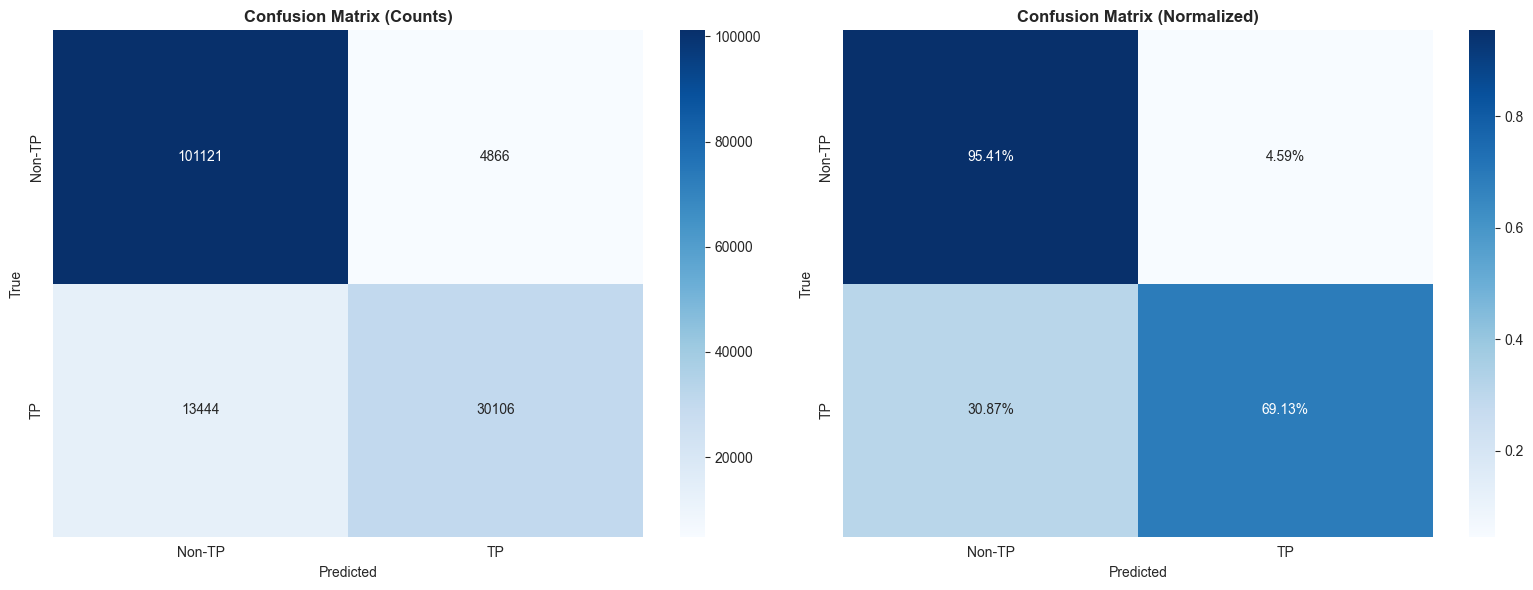

In [35]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-TP', 'TP'],
            yticklabels=['Non-TP', 'TP'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Non-TP', 'TP'],
            yticklabels=['Non-TP', 'TP'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 12. ROC Curve

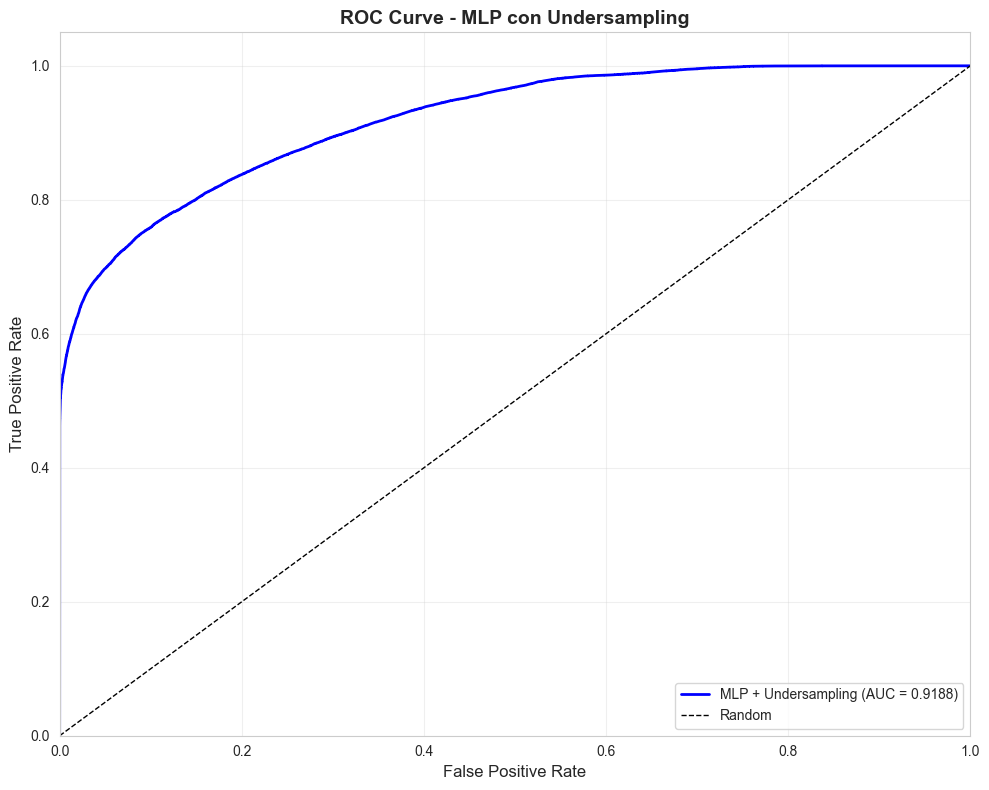

In [36]:
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'MLP + Undersampling (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - MLP con Undersampling', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

**MLP con Random UnderSampling**

**Strategia:** Riduzione classe maggioritaria (Non-TP) a ratio 1.5:1

**Vantaggi undersampling:**
- ✅ Training ~66% più veloce (meno sample)
- ✅ Nessun sample sintetico (vs SMOTE)
- ✅ No class weights necessari
- ✅ Riduce bias verso classe maggioritaria

**Svantaggi:**
- ⚠️ Perde informazione (scarta sample classe maggioritaria)
- ⚠️ Può underfittare se troppo aggressivo

**Confronto con baseline:**
- Baseline: 314k samples + class weights
- Questo: ~167k samples, no class weights

**Varianti da provare:**
- `sampling_strategy=1.0` → bilanciamento completo (1:1)
- `sampling_strategy=2.0` → più conservativo (2:1)
- **TomekLinks** o **NearMiss** → undersampling intelligente

## 13. Salvataggio Modello e Metriche

In [38]:
from pathlib import Path
import os
from datetime import datetime

# Crea directory per il modello
model_dir = Path('../models/mlp_undersampling')
model_dir.mkdir(parents=True, exist_ok=True)

# Salva modello PyTorch
model_path = model_dir / 'model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'dropout': 0.3,
    'n_epochs': n_epochs,
    'final_loss': train_losses[-1]
}, model_path)

print(f"✅ Modello salvato: {model_path}")

# Salva anche solo i pesi (per caricamento più semplice)
weights_path = model_dir / 'model_weights.pth'
torch.save(model.state_dict(), weights_path)
print(f"✅ Pesi salvati: {weights_path}")

✅ Modello salvato: ../models/mlp_undersampling/model.pth
✅ Pesi salvati: ../models/mlp_undersampling/model_weights.pth


In [41]:
import json
from sklearn.metrics import accuracy_score

# Calcola metriche dettagliate per ogni classe
precision_0 = precision_score(y_true, y_pred, pos_label=0)
recall_0 = recall_score(y_true, y_pred, pos_label=0)
f1_0 = f1_score(y_true, y_pred, pos_label=0)

precision_1 = precision_score(y_true, y_pred, pos_label=1)
recall_1 = recall_score(y_true, y_pred, pos_label=1)
f1_1 = f1_score(y_true, y_pred, pos_label=1)

# Salva metriche in JSON
metrics = {
    "model_name": "MLP_Undersampling",
    "timestamp": datetime.now().isoformat(),
    "dataset_version": "processed_v3_balanced",
    "undersampling_strategy": "RandomUnderSampler (1.5:1 ratio)",
    "architecture": {
        "input_dim": input_dim,
        "hidden_layers": [128, 64, 32],
        "dropout": 0.3,
        "activation": "ReLU",
        "output_activation": "Sigmoid"
    },
    "training": {
        "n_epochs": n_epochs,
        "batch_size": 512,
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss_function": "BCEWithLogitsLoss",
        "device": str(device)
    },
    "data": {
        "n_train_samples_original": len(y_train),
        "n_train_samples_resampled": len(y_train_resampled),
        "n_test_samples": len(y_test),
        "n_features": input_dim,
        "reduction_percentage": float((1 - len(y_train_resampled)/len(y_train)) * 100),
        "class_distribution_resampled": {
            "class_0": int(pd.Series(y_train_resampled).value_counts()[0]),
            "class_1": int(pd.Series(y_train_resampled).value_counts()[1])
        }
    },
    "test_metrics": {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "roc_auc": float(roc_auc)
    },
    "per_class_metrics": {
        "class_0_non_tp": {
            "precision": float(precision_0),
            "recall": float(recall_0),
            "f1_score": float(f1_0)
        },
        "class_1_tp": {
            "precision": float(precision_1),
            "recall": float(recall_1),
            "f1_score": float(f1_1)
        }
    },
    "confusion_matrix": {
        "true_negatives": int(cm[0, 0]),
        "false_positives": int(cm[0, 1]),
        "false_negatives": int(cm[1, 0]),
        "true_positives": int(cm[1, 1])
    },
    "training_history": {
        "final_loss": float(train_losses[-1]),
        "min_loss": float(min(train_losses)),
        "loss_history": [float(loss) for loss in train_losses]
    }
}

metrics_path = model_dir / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metriche salvate: {metrics_path}")

print(f"\n{'='*60}")
print("RIEPILOGO SALVATAGGIO")
print(f"{'='*60}")
print(f"Directory: {model_dir}")
print(f"  - model.pth (modello completo)")
print(f"  - model_weights.pth (solo pesi)")
print(f"  - metrics.json (metriche)")
print(f"{'='*60}")

✅ Metriche salvate: ../models/mlp_undersampling/metrics.json

RIEPILOGO SALVATAGGIO
Directory: ../models/mlp_undersampling
  - model.pth (modello completo)
  - model_weights.pth (solo pesi)
  - metrics.json (metriche)


### 13.1 Come Caricare il Modello

Per ricaricare il modello salvato:

```python
# Carica pesi
model = MLP(input_dim=43, dropout=0.3)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

# Oppure carica tutto (con optimizer)
checkpoint = torch.load('model.pth')
model = MLP(input_dim=checkpoint['input_dim'], dropout=checkpoint['dropout'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
```